In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV

import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, average_precision_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Data Preparation

In [2]:
warnings.filterwarnings('ignore')
original_data = pd.read_csv('train_data.csv',index_col=0)
# Split the original data into two subsets, eval_data is used for model comparison
train_data, valid_data = train_test_split(original_data, test_size=0.3, random_state=0, shuffle=True)
train_data.index = range(len(train_data))

In [3]:
train_data = pd.concat([train_data, valid_data], axis=0)
train_data.index = range(len(train_data))
train_data.loc[train_data['OCCUPATION']!=1,'OCCUPATION'] = 0
cat_vars = ['MARRIAGE', 'EDUCATION']
encoders = [OneHotEncoder(categories='auto') for _ in range(len(cat_vars))] 
encoded_tr = [encoders[i].fit_transform(train_data[[cat_var]]).todense() for i,cat_var in enumerate(cat_vars)]
X = pd.concat([train_data.iloc[:,:-1].drop(cat_vars, axis=1), 
                     pd.DataFrame(np.concatenate(encoded_tr, axis=1))], axis=1)
y = train_data.iloc[:,-1] 
X = X.rename(columns={0:'Marriage 1',1:'Marriage 2',2:'Marriage 3',3:'Edu 1',4:'Edu 2',5:'Edu 3',
                                  6:'Edu 4',7:'Edu 5',8:'Edu 6',9:'Edu 7'})
X = X.drop(['Marriage 3','Edu 7'], axis=1)

X_valid = pd.DataFrame(X.iloc[-len(valid_data):])
y_valid = train_data.iloc[-len(valid_data):,-1] 
X.drop(X.tail(len(valid_data)).index, inplace=True)
y.drop(y.tail(len(valid_data)).index, inplace=True)

for i in [0,1,2,3,4,5,8]:
    X1 = X.iloc[:,i]
    mean = X1.mean()
    std = X1.std()
    X.iloc[:,i] = (X.iloc[:,i]-mean)/std
    X_valid.iloc[:,i] = (X_valid.iloc[:,i]-mean)/std

In [4]:
X.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,INCOME,CREDIT_PROFILE,Marriage 1,Marriage 2,Edu 1,Edu 2,Edu 3,Edu 4,Edu 5,Edu 6
0,-0.146091,0.347996,1.890029,0.432950,1.266862,0.111744,0,0,-0.904027,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.229710,-1.005322,-1.130328,-0.819964,-0.609370,-0.336397,0,1,0.196528,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.271358,-1.343651,-0.314015,-0.723586,0.055930,0.559885,0,0,0.196528,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.521891,0.686325,0.175772,-0.241696,1.705647,-0.560467,1,1,0.196528,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.605511,1.362984,-0.558909,-0.771775,-0.324445,-0.560467,1,1,1.572221,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Fitting the models

#### Create a custom score to compare different models

In [5]:
from sklearn.metrics import make_scorer

n_test = X_valid.shape[0]
def cm_TP_TF(y_valid,y_pred):
    cm = (confusion_matrix(y_valid,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    TP = cm[0][0]                                                                               # True Positives
    FN = cm[0][1]                                                                               # False Positives
    FP = cm[1][0]                                                                               # True Negatives
    TN = cm[1][1]   
    TPR = TP/(TP+FN)
    TNR = TN/(FP+TN)
    return((TPR+TNR)/2)

custom_score = make_scorer(cm_TP_TF, greater_is_better = True)

### Naive Bayes Classifier -- Perform feature selection first

In [6]:
# Naive Bayes Classifier depends on the assumption of conditionally independent, so we will do feature selection first to mitigate the dependent problem.
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X, y)
embeded_lr_support = embeded_lr_selector.get_support()
X_new = X.loc[:,embeded_lr_support]
X_valid_new = X_valid.loc[:,embeded_lr_support]

embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

# Try Naive Bayes Classifier
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_new, y).predict(X_valid_new)
print('NaiveBayes_averageTP&TN=',cm_TP_TF(y_valid,y_pred_gnb))

NaiveBayes_averageTP&TN= 0.8340126811594203


### Other classification models

In [7]:
def clf_fitting(X_train, y_train, X_validation, y_validation):
    
    # Random forest
    clf_rf = RandomForestClassifier(n_estimators=200)
    y_pred_rf=clf_rf.fit(X_train, y_train).predict(X_validation)
    print('RandomForest average TP&TN=',cm_TP_TF(y_validation,y_pred_rf))

    
    # Support Vector Classifier                        
    clf_svm = svm.SVC(gamma='auto',C=1, kernel='linear')
    y_pred_svm=clf_svm.fit(X_train, y_train).predict(X_validation)
    print('SupportVector average TP&TN=',cm_TP_TF(y_validation,y_pred_svm))
    
    # Gradient Boosting
    boosting=GradientBoostingClassifier(random_state=0)
    y_pred=boosting.fit(X_train, y_train).predict(X_validation)
    print('Gradient Boosting average TP&TN=',cm_TP_TF(y_validation,y_pred))
    
    # Ensemble
    bagging = BaggingClassifier(n_estimators=50,bootstrap=True,bootstrap_features=True, random_state=0)
    y_pred_bagging = bagging.fit(X_train,y_train).predict(X_validation)
    print('Ensemble average TP&TN=',cm_TP_TF(y_validation,y_pred_bagging))
    
    # Modification for softmargin (SupportVector)
    clf_msvm = svm.SVC(gamma='auto',C=0.1, kernel='linear')
    y_pred_msvm=clf_msvm.fit(X_train, y_train).predict(X_validation)
    print('Modifiedsvm average TP&TN=',cm_TP_TF(y_validation,y_pred_msvm))      

In [8]:
clf_fitting(X, y, X_valid,y_valid)

RandomForest average TP&TN= 0.8525815217391305
SupportVector average TP&TN= 0.8804347826086957
Gradient Boosting average TP&TN= 0.8826992753623188
Ensemble average TP&TN= 0.8485054347826088
Modifiedsvm average TP&TN= 0.8804347826086957


### According to the result above, SupportVector and Gradient Boosting are the best performers, therefore we trained these two models to improve there performances furthermore. 

## Tunning the parameters in Gradient Boosting -- 1/2(TPR+TNR)=0.8868

##### Create a baseline GB model named GBM0

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, average_precision_score
# define a function to do cv and GB
def fitmodel(model, X, y, PerformCV = True, predprob_exist = True, PrintFeatureImportance=True, cv_folds=5):
    #Fitting the model
    model.fit(X,y)
    
    #prediction on target variable
    y_pred = model.predict(X_valid)
    cm = (confusion_matrix(y_valid,y_pred,labels=[1, 0],sample_weight=None)/n_test)*100
    TP = cm[0][0]                                                                               # True Positives
    FN = cm[0][1]                                                                               # False Positives
    FP = cm[1][0]                                                                               # True Negatives
    TN = cm[1][1]   
    TPR = TP/(TP+FN)
    TNR = TN/(FP+TN)
    
    if predprob_exist:
        y_predprob = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = roc_curve(y_valid, y_predprob)
        roc_auc = auc(fpr,tpr)
        print ("AUC Score: %f" % roc_auc)
    
    #perform cross-validation
    if PerformCV:
        cv_score = cross_val_score(model, X, y, cv=cv_folds, scoring = custom_score)
    
    #print model report
    print ("\nModel Report")
    print ("Average of True Positive and True Negative Rates = {:.4f}".format((TPR+TNR)/2))
    print ("Accuracy : %4g" % accuracy_score(y_pred,y_valid))

    if PerformCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g " % (np.mean(cv_score), np.std(cv_score),np.min(cv_score),np.max(cv_score)))
   
    #print feature important
    if PrintFeatureImportance:
        fea_import = pd.Series(model.feature_importances_, X.columns).sort_values(ascending = True)
        fea_import.plot(kind = "barh", title = "Feature Importances")
        plt.xlabel('feature importances score')    
        

AUC Score: 0.908364

Model Report
Average of True Positive and True Negative Rates = 0.8827
Accuracy : 0.884848
CV Score : Mean - 0.8085269 | Std - 0.04706701 | Min - 0.7468688 | Max - 0.8729675 


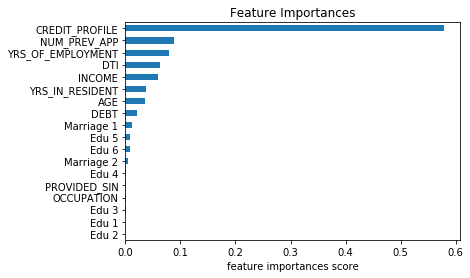

In [10]:
GBM0 = GradientBoostingClassifier(random_state=0)
fitmodel(GBM0, X, y)

##### Steps taken to train the model:
1. choose a learning rate first (btw 0.05 and 0.2)
2. then use cv to find the optimal n_estimator(number of trees:40-70)
3. tunning the tree parameters(ie max_depth, min_split_leaf, ets..) using cv
3. reduce the learning rate maybe

##### Set initial tree parameters:
1. min_ samples_ split=50 (0.5-1%)
2. min_ samples_ leaf=5
3. max_ depth=4
4. max_ features='sqrt'
5. subsample=0.8


In [11]:
# choose an optimal n_estimators based on the learning rate of 0.1
param_test1 = {'n_estimators': range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, min_samples_split = 50, min_samples_leaf = 5, max_depth = 4, max_features = 'sqrt', subsample = 0.8, random_state = 0), 
                        param_grid = param_test1, scoring = custom_score, cv = 5, iid = False, n_jobs = 4 )
gsearch1.fit(X, y)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.8471249908445031)

##### With 0.05 learning rate, the optimal n_estimators is 70
Tunning the tree parameter based on the ranking below:
1. max_depth and min_samples_split
2. min_samples_leaf
3. max_features

In [12]:
param_test2 = {'max_depth': range(2,8,1), 'min_samples_split': range(10,100,10)}  #Small min_samples_split will lead to over-fitting problem
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 70, max_features = 'sqrt', subsample = 0.8, random_state = 0), 
                        param_grid = param_test2, scoring = custom_score, cv = 5, iid = False, n_jobs = 4)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_samples_split': 20}, 0.8623756683512781)

In [13]:
param_test3 = {'min_samples_leaf': range(1,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 70, max_features =  'sqrt', max_depth = 2, min_samples_split = 20, subsample = 0.8, random_state = 0 ),
                        param_grid = param_test3, scoring = custom_score, cv = 5, iid = False, n_jobs = 4)
gsearch3.fit(X,y)
gsearch3.best_params_ , gsearch3.best_score_


({'min_samples_leaf': 1}, 0.8623756683512781)

AUC Score: 0.924517

Model Report
Average of True Positive and True Negative Rates = 0.8816
Accuracy : 0.878788
CV Score : Mean - 0.8623757 | Std - 0.0370172 | Min - 0.806526 | Max - 0.8990515 


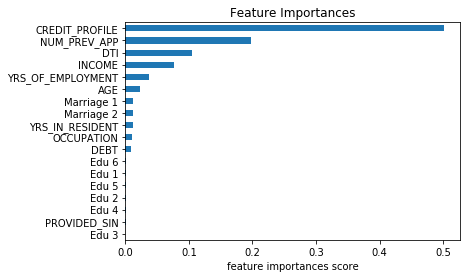

In [14]:
fitmodel(gsearch3.best_estimator_, X, y)

The std of CV Score has decreased, and the mean of CV score has increased
Moreover, feature importances score became more even

In [15]:
param_test4 = {'max_features': range(1,5,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 70, min_samples_leaf = 1, max_depth = 2, min_samples_split = 20, subsample = 0.8, random_state = 0 ),
                        param_grid = param_test4, scoring = custom_score, cv = 5, iid = False, n_jobs = 4)
gsearch4.fit(X,y)
gsearch4.best_params_ , gsearch4.best_score_

({'max_features': 4}, 0.8623756683512781)

In [16]:
# Find the optimal subsample(percent of total obs used to estimator each tree)
param_test5 = {'subsample': [0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 70, max_features = 4, min_samples_leaf = 1, max_depth = 2, min_samples_split = 20, random_state = 0 ),
                        param_grid = param_test5, scoring = custom_score, cv = 5, iid = False, n_jobs = 4)
gsearch5.fit(X,y)
gsearch5.best_params_ , gsearch5.best_score_

({'subsample': 0.6}, 0.865153446129056)

To summarize, the optimal tree parameters are: 
1. max_depth = 2
2. min_samples_split = 20
3. min_sample_leaf = 1
4. max_features = 4
5. subsample = 0.6

##### Plug in the optimal parameter and fit the GBmodel again

AUC Score: 0.927536

Model Report
Average of True Positive and True Negative Rates = 0.8868
Accuracy : 0.884848
CV Score : Mean - 0.8651534 | Std - 0.03970721 | Min - 0.806526 | Max - 0.9078591 


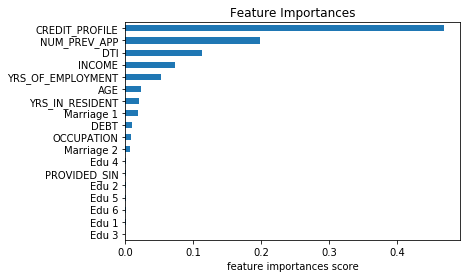

In [17]:
GBM_tuned_1 = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 70, max_depth = 2, min_samples_split = 20,
                                        min_samples_leaf = 1, max_features = 4, subsample = 0.6, random_state = 0)
fitmodel(GBM_tuned_1,X,y)

##### Step 4: Lower the learning rate gradually to make the performance more stable (n_estimator should increase at the same time)

AUC Score: 0.929197

Model Report
Average of True Positive and True Negative Rates = 0.8868
Accuracy : 0.884848
CV Score : Mean - 0.8592591 | Std - 0.03035026 | Min - 0.8187212 | Max - 0.8990515 


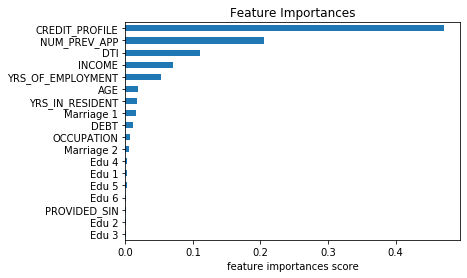

In [18]:
GBM_tuned_2 = GradientBoostingClassifier(learning_rate = 0.025, n_estimators = 140, max_depth = 2, min_samples_split = 20,
                                        min_samples_leaf = 1, max_features = 4, subsample = 0.6, random_state = 0)
fitmodel(GBM_tuned_2,X,y)

## Support Vector Classifier (SVC) - Tunning parameters

#### Baseline SVC (with default parameter)

In [19]:
svc = svm.SVC(kernel = 'linear', gamma = 'auto')
fitmodel(svc, X, y, predprob_exist = False, PrintFeatureImportance = False)


Model Report
Average of True Positive and True Negative Rates = 0.8804
Accuracy : 0.872727
CV Score : Mean - 0.8397572 | Std - 0.03749425 | Min - 0.7722222 | Max - 0.8851626 


Parameters in SVC:
1. C (penalty on misclassification)
2. kernel 
3. gamma (decline rate)

In [20]:
X.shape

(385, 18)

why 'precomputed' method cannot use gridsearch to test?

In [21]:
param_test1 = {'kernel': ['linear','poly','rbf','sigmoid']}
gsearch1 = GridSearchCV(estimator = svm.SVC(), param_grid = param_test1, cv =5, iid = False, scoring = custom_score, n_jobs = 4)
gsearch1.fit(X,y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.01250501, 0.01974144, 0.01368179, 0.01548429]),
  'std_fit_time': array([0.00435468, 0.00344225, 0.00564259, 0.00707636]),
  'mean_score_time': array([0.00360532, 0.00658278, 0.00447221, 0.0046412 ]),
  'std_score_time': array([0.00036867, 0.00164161, 0.00095802, 0.00191926]),
  'param_kernel': masked_array(data=['linear', 'poly', 'rbf', 'sigmoid'],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'kernel': 'linear'},
   {'kernel': 'poly'},
   {'kernel': 'rbf'},
   {'kernel': 'sigmoid'}],
  'split0_test_score': array([0.85102175, 0.66348055, 0.84970336, 0.83487146]),
  'split1_test_score': array([0.8851626 , 0.7100271 , 0.85907859, 0.91124661]),
  'split2_test_score': array([0.85569106, 0.66836043, 0.85907859, 0.85738482]),
  'split3_test_score': array([0.83468835, 0.72560976, 0.85907859, 0.87127371]),
  'split4_test_score': array([0.77222222, 0.69583333, 0.77222222, 0.79305556]),
  'mean_t

In [22]:
param_test2 = {'gamma': np.linspace(0.001,0.6,20)}
gsearch2 = GridSearchCV(estimator = svm.SVC(kernel = 'sigmoid'), param_grid = param_test2, cv =5, iid = False, scoring = custom_score, n_jobs = 4)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.03252631578947368}, 0.8597526184721307)

In [23]:
param_test3 = {'C': np.linspace(0.1,3,20)}
gsearch3 = GridSearchCV(estimator = svm.SVC(kernel = 'sigmoid', gamma = 0.03252631578947368), param_grid = param_test3, cv =5, iid = False, scoring = custom_score, n_jobs = 4)
gsearch3.fit(X,y)
gsearch3.best_params_, gsearch3.best_score_

({'C': 2.236842105263158}, 0.8653935032593569)

In [24]:
model = svm.SVC(C =2.236842105263158, kernel = 'sigmoid', gamma = 0.03252631578947368)
fitmodel(model, X, y, predprob_exist = False, PrintFeatureImportance = False)


Model Report
Average of True Positive and True Negative Rates = 0.8784
Accuracy : 0.872727
CV Score : Mean - 0.8653935 | Std - 0.02684438 | Min - 0.8208333 | Max - 0.8973577 


Comparing the result above with the cv score from Gradient Boosting Model:

Average of True Positive and True Negative Rates = 0.8868
Accuracy : 0.884848
AUC Score: 0.929197
CV Score : Mean - 0.8592591 | Std - 0.03035026 | Min - 0.8187212 | Max - 0.8990515 


##### To summarize, the average performance of SVC is higher than GBM, and it has lower std.

## Neural Network

In [133]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(alpha = 0.6)
fitmodel(model, X, y, predprob_exist = True, PrintFeatureImportance = False)

AUC Score: 0.915761

Model Report
Average of True Positive and True Negative Rates = 0.8526
Accuracy : 0.854545
CV Score : Mean - 0.8471448 | Std - 0.02803505 | Min - 0.8078444 | Max - 0.8800813 


class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

In [63]:
# Print out the default hyperparameters
model = MLPClassifier()
print(model)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [142]:
param_test1 = {'alpha': [10**i for i in np.linspace(-3,0,20)]}
gsearch1 = GridSearchCV(estimator = MLPClassifier(), param_grid = param_test1, cv=5, scoring = custom_score, iid = False, n_jobs = 4 )
gsearch1. fit(X,y)
gsearch1.best_params_, gsearch1.best_score_

({'alpha': 0.23357214690901212}, 0.8526252471984179)

In [145]:
param_test1 = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']}
gsearch1 = GridSearchCV(estimator = MLPClassifier(alpha =  0.2335), param_grid = param_test1, cv=5, scoring = custom_score, iid = False, n_jobs = 4 )
gsearch1. fit(X,y)
gsearch1.best_params_, gsearch1.best_score_

({'activation': 'identity', 'solver': 'adam'}, 0.8581808027539735)

In [146]:
# Using grid search to find the optimal hidden_layer_sizes
mytuple =[]
j=20
for i in range(5,10):
    ituple = (j,)*i
    j = j+20
    mytuple.append(ituple)
    
param_test2 = {'hidden_layer_sizes': mytuple}
gsearch2 = GridSearchCV(estimator = MLPClassifier(activation = 'identity', solver = 'adam', alpha =  0.2335, max_iter = 10), param_grid = param_test2, cv = 10, scoring = custom_score, n_jobs = 4, iid = False)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_

({'hidden_layer_sizes': (80, 80, 80, 80, 80, 80, 80, 80)}, 0.8590350877192983)

In [151]:
model = MLPClassifier(activation = 'identity', solver =  'adam', hidden_layer_sizes = (80, 80, 80, 80, 80, 80, 80, 80), max_iter = 10, alpha =  0.2335)
fitmodel(model, X, y, PrintFeatureImportance = False)

AUC Score: 0.906401

Model Report
Average of True Positive and True Negative Rates = 0.8712
Accuracy : 0.866667
CV Score : Mean - 0.8638724 | Std - 0.03660143 | Min - 0.8078444 | Max - 0.8973577 


In [155]:
model = MLPClassifier(activation = 'identity', solver =  'lbfgs', hidden_layer_sizes = (40,40,40,40,40,40), max_iter = 10, alpha =  0.2335)
fitmodel(model, X, y, PrintFeatureImportance = False)

AUC Score: 0.908816

Model Report
Average of True Positive and True Negative Rates = 0.8712
Accuracy : 0.866667
CV Score : Mean - 0.8642112 | Std - 0.03245611 | Min - 0.8200396 | Max - 0.8990515 


In [157]:
y_pred_prob = model.predict_proba(X_valid)[:,1]
Thresholds = np.linspace(0,1,10)
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate", "(TPR+TNR)/2"]) # df to store results
results['THRESHOLD'] = Thresholds                                                           # threshold column
for i in range(len(Thresholds)):
    y_pred1 = np.where(y_pred_prob>Thresholds[i],1,0)
    valid_accuracy = accuracy_score(y_valid,y_pred1)
    TN, FP, FN, TP = confusion_matrix(y_valid,y_pred1,sample_weight=None).ravel()
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    results.iloc[i,1] = valid_accuracy 
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR                                                              
    results.iloc[i,4] = (TPR+TNR)/2
results.style.hide_index()
print(results.T.to_string(header=False))

THRESHOLD                  0  0.111111  0.222222  0.333333  0.444444  0.555556  0.666667  0.777778  0.888889         1
accuracy            0.418182  0.745455  0.848485  0.860606  0.860606  0.872727  0.824242  0.793939  0.757576  0.581818
true positive rate         1  0.927536  0.927536  0.913043  0.898551  0.855072  0.695652  0.594203  0.478261         0
true negative rate         0  0.614583  0.791667  0.822917  0.833333  0.885417  0.916667    0.9375  0.958333         1
(TPR+TNR)/2              0.5   0.77106  0.859601   0.86798  0.865942  0.870245  0.806159  0.765851  0.718297       0.5


In [158]:
y_pred1 = np.where(y_pred_prob>0.5555,1,0)
cm_TP_TF(y_pred1,y_valid)

0.868796992481203